In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from joblib import dump, load
from mpl_toolkits import mplot3d
np.set_printoptions(suppress=True)
seed = 2
import random
random.seed(seed)
numpy.random.seed(seed)

plt.rcParams['figure.figsize'] = [13, 7]

Using TensorFlow backend.


# 1 Unity model compensation

In [2]:
simulated_kinematicsMass1 = pd.read_csv("datasets/final/simulated_kinematicsMass1.csv")
simulated_kinematicsMass2 = pd.read_csv("datasets/final/simulated_kinematicsMass2.csv")
simulated_kinematicsMass1.head()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
0,3.475065,6.319557,3.252033,6.199712,-1.750435,0.669063,0.251564,-1.741295,0.722219,0.250060
1,6.524433,2.353384,6.636117,2.647309,2.327339,1.562356,-0.247116,2.314363,1.640779,-0.244972
2,3.031746,7.407318,1.699376,6.968842,-2.869240,1.472744,1.061052,-2.854805,1.527632,1.050600
3,3.980741,4.760850,4.056306,4.824212,-0.428696,1.540483,-0.101672,-0.426212,1.642761,-0.101221
4,4.767809,4.939977,4.445458,4.629630,-0.105026,0.746711,0.497138,-0.104461,0.808752,0.494984


In [3]:
simulated_kinematicsMass1.describe()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
count,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000,10247.000000
mean,4.814563,4.835339,4.815222,4.833939,-0.011194,0.952914,-0.000483,-0.011132,1.014969,-0.000518
std,1.775273,1.768960,1.774361,1.773661,2.141675,0.543062,0.695314,2.130935,0.560725,0.691149
min,0.890962,1.043345,0.888020,0.962035,-3.718945,0.000299,-1.211567,-3.699937,0.036173,-1.199671
25%,3.291643,3.319602,3.327045,3.309525,-1.866616,0.494803,-0.591677,-1.856859,0.541150,-0.588149
50%,4.664921,4.716073,4.664052,4.744818,-0.051115,0.945453,-0.003681,-0.050831,1.002080,-0.003650
75%,6.335452,6.333607,6.306544,6.338410,1.841194,1.423308,0.603634,1.831209,1.497661,0.599918
max,8.495335,8.435907,8.463227,8.508593,3.714941,1.949880,1.211864,3.699413,1.999475,1.199380


In [4]:
simulated_kinematicsMass2.describe()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
count,10925.000000,10925.000000,10925.000000,10925.000000,10925.000000,10925.000000,10925.000000,10925.000000,10925.000000,10925.000000
mean,4.815052,4.817905,4.816675,4.821773,-0.003398,0.948988,-0.005058,-0.003402,1.036183,-0.005094
std,1.778387,1.785950,1.782583,1.784065,2.150672,0.531995,0.692339,2.138700,0.561514,0.694570
min,0.933910,1.031371,0.921917,0.894623,-3.716579,0.000074,-1.206707,-3.699512,0.044470,-1.200000
25%,3.283596,3.291703,3.324365,3.307719,-1.876204,0.490480,-0.604363,-1.863765,0.553519,-0.605915
50%,4.697691,4.687732,4.683014,4.672706,0.006725,0.960882,-0.017403,0.006679,1.037897,-0.017513
75%,6.341100,6.342680,6.352989,6.344541,1.870422,1.415051,0.599182,1.858386,1.520082,0.601139
max,8.444760,8.516881,8.538361,8.428403,3.715263,1.926912,1.210193,3.699004,1.999578,1.199945


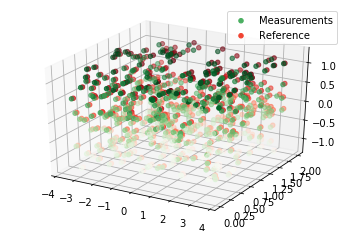

In [5]:
#lest vizualise some data
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = simulated_kinematicsMass1["z"][0:500]
xdata = simulated_kinematicsMass1["x"][0:500]
ydata = simulated_kinematicsMass1["y"][0:500]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
zdata = simulated_kinematicsMass1["tz"][0:500]
xdata = simulated_kinematicsMass1["tx"][0:500]
ydata = simulated_kinematicsMass1["ty"][0:500]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
ax.legend(['Measurements', 'Reference'])


In [6]:
#lets convert frame from unity to robot frame

def Unity2R(x,y,z):
    return z,-x,y
        
def R2Unity(x,y,z):
    return -y,z,x

sim_X1 = pd.DataFrame(columns=['x', 'y', 'z'])
sim_M1 = pd.DataFrame(columns=['tx', 'ty', 'tz'])

for index, row in simulated_kinematicsMass1.iterrows():
    x,y,z = Unity2R(row["x"],row["y"],row["z"])
    sim_X1 = sim_X1.append({'x': x,'y': y,'z': z }, ignore_index=True)
    
for index, row in simulated_kinematicsMass1.iterrows():
    x,y,z = Unity2R(row["tx"],row["ty"],row["tz"])
    sim_M1 = sim_M1.append({'tx': x,'ty': y,'tz': z }, ignore_index=True) 
    
sim_X2 = pd.DataFrame(columns=['x', 'y', 'z'])
sim_M2 = pd.DataFrame(columns=['tx', 'ty', 'tz'])

for index, row in simulated_kinematicsMass2.iterrows():
    x,y,z = Unity2R(row["x"],row["y"],row["z"])
    sim_X2 = sim_X2.append({'x': x,'y': y,'z': z }, ignore_index=True)
    
for index, row in simulated_kinematicsMass2.iterrows():
    x,y,z = Unity2R(row["tx"],row["ty"],row["tz"])
    sim_M2 = sim_M2.append({'tx': x,'ty': y,'tz': z }, ignore_index=True) 
    

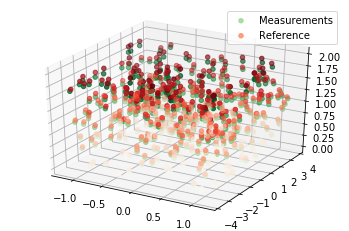

In [7]:
#lest vizualise some data
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = sim_X1["z"][0:500]
xdata = sim_X1["x"][0:500]
ydata = sim_X1["y"][0:500]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
zdata = sim_M1["tz"][0:500]
xdata = sim_M1["tx"][0:500]
ydata = sim_M1["ty"][0:500]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
ax.legend(['Measurements', 'Reference'])

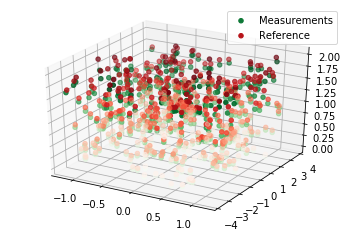

In [8]:
#lest vizualise some data
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = sim_X2["z"][0:500]
xdata = sim_X2["x"][0:500]
ydata = sim_X2["y"][0:500]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
zdata = sim_M2["tz"][0:500]
xdata = sim_M2["tx"][0:500]
ydata = sim_M2["ty"][0:500]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
ax.legend(['Measurements', 'Reference'])

In [9]:
sim_Y1=pd.DataFrame()
sim_Y1["ex"] = sim_M1["tx"]-sim_X1["x"]
sim_Y1["ey"] = sim_M1["ty"]-sim_X1["y"]
sim_Y1["ez"] = sim_M1["tz"]-sim_X1["z"]
sim_Y1.describe()

,ex,ey,ez
count,10247.000000,10247.000000,10247.000000
mean,-0.000035,-0.000062,0.062056
std,0.004490,0.010777,0.023072
min,-0.015924,-0.019014,0.029428
25%,-0.003727,-0.010052,0.045648
50%,0.000021,-0.000276,0.055537
75%,0.003604,0.009941,0.073790
max,0.015353,0.019030,0.145920


In [10]:
sim_Y2=pd.DataFrame()
sim_Y2["ex"] = sim_M2["tx"]-sim_X2["x"]
sim_Y2["ey"] = sim_M2["ty"]-sim_X2["y"]
sim_Y2["ez"] = sim_M2["tz"]-sim_X2["z"]
sim_Y2.describe()

,ex,ey,ez
count,10925.000000,10925.000000,10925.000000
mean,-0.000036,0.000004,0.087195
std,0.005257,0.012154,0.039404
min,-0.022484,-0.021307,0.039771
25%,-0.002651,-0.011884,0.059208
50%,-0.000021,0.000048,0.074501
75%,0.002588,0.011802,0.103930
max,0.023451,0.021475,0.244483


In [11]:
err=mean_absolute_error(np.zeros(sim_Y1.shape),sim_Y1)
print("Error in sim mass 1: "+str(err))

Error in sim mass 1: 0.025092005953254632


In [12]:
err=mean_absolute_error(np.zeros(sim_Y2.shape),sim_Y2)
print("Error in sim mass 2: "+str(err))

Error in sim mass 2: 0.03393766484421768


In [13]:
scalerX1 = StandardScaler()
sim_X1_scaled = scalerX1.fit_transform(sim_X1)
dump(scalerX1, 'sim_scalerX1.joblib')

scalerX2 = StandardScaler()
sim_X2_scaled = scalerX2.fit_transform(sim_X2)
dump(scalerX2, 'sim_scalerX2.joblib')

sim_X2_scaled_X1 = scalerX1.fit_transform(sim_X2)




In [14]:
def baseline_model(activation='tanh'):
    model = Sequential()
    model.add(Dense(8, input_dim=3, kernel_initializer='normal', activation=activation))
    model.add(Dense(3, kernel_initializer='normal'))
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mean_absolute_error'])
    return model

In [15]:
arr=[]
arr1 = [0,1,2]
arr2 = [0,1,1]
arr.append(arr1)
arr.append(arr2)
arr.append(arr2)
print(arr)

#pure python crossval
def mean(a):
    return sum(a) / len(a)

def mean_results(res):
    return list(map(mean, zip(*res)))
    
print(mean_results(arr))

num_attempts=4

[[0, 1, 2], [0, 1, 1], [0, 1, 1]]
[0.0, 1.0, 1.3333333333333333]


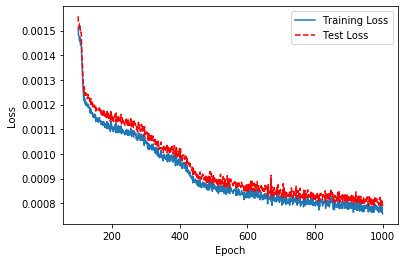

[0.0008120655742750912, 0.0007925187780718474, 0.0008141158937973481, 0.0008040518998789258]


In [16]:
#params
epochs=10
fromepochs=round(1000/epochs)
toepochs=round(10000/epochs)

plt_err1=[]
plt_err2=[]

for attempt in range(num_attempts):
    #generate samples, train and evaluate
    X_train, X_test, y_train, y_test = train_test_split(sim_X1_scaled, sim_Y1, test_size=0.8, random_state=seed+attempt)
    y_train.describe()

    model = baseline_model(activation='tanh')

    def train(ep):
        model.fit(X_train,y_train,epochs=epochs,batch_size=300, verbose=0)
        pred1=model.predict(X_train)
        pred2=model.predict(X_test)
        err1=mean_absolute_error(pred1,y_train)
        err2=mean_absolute_error(pred2,y_test)
        return err1,err2

    plt_err1_l=[]
    plt_err2_l=[]
    epch=[]
    for ep in range(1,toepochs):
        err1,err2=train(ep)
        plt_err1_l.append(err1)
        plt_err2_l.append(err2)
        epch.append(ep)
    model.save('sim_modelX1.h5')
    
    plt_err1.append(plt_err1_l)
    plt_err2.append(plt_err2_l)
    
#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)

plt.plot(epch[fromepochs:],plt_err1[fromepochs:],label="Training Loss")
plt.plot(epch[fromepochs:],plt_err2[fromepochs:],'r--',label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt_err2[-5:-1])
#with scaling [0.0008571595238669327, 0.0008648160827657058, 0.0009000820402912723, 0.0009091522574097019]


backup=pd.DataFrame()
backup["epch"] = epch
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup.to_csv("figure7.csv", index = None, header=True)


# 2 Unity model tranfer learning

In [ ]:
#with new scaling

plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]

for attempt in range(num_attempts):
    X_train, X_test, y_train, y_test = train_test_split(sim_X2_scaled, sim_Y2, test_size=0.8, random_state=seed+attempt)


    plt_err1_l=[]
    plt_err2_l=[]
    plt_err1_linear_l=[]
    plt_err2_linear_l=[]
    plt_err1_transferred_l=[]
    plt_err2_transferred_l=[]
    numsamples=[]


    for numsample in range(2, 15):
        print("Estimating num samples: "+str(numsample*10))
        modelTransferred = keras.models.load_model('sim_modelX1.h5')
        model_linear = LinearRegression()
        modelNew = baseline_model(activation='tanh')

        modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
        pred1=modelNew.predict(X_train)
        pred2=modelNew.predict(X_test)
        err1=mean_absolute_error(pred1,y_train)
        err2=mean_absolute_error(pred2,y_test)

        modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
        pred1=modelTransferred.predict(X_train)
        pred2=modelTransferred.predict(X_test)
        err3=mean_absolute_error(pred1,y_train)
        err4=mean_absolute_error(pred2,y_test)

        model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
        pred1=model_linear.predict(X_train)
        pred2=model_linear.predict(X_test)
        err5=mean_absolute_error(pred1,y_train)
        err6=mean_absolute_error(pred2,y_test)

        plt_err1_l.append(err1)
        plt_err2_l.append(err2)

        plt_err1_transferred_l.append(err3)
        plt_err2_transferred_l.append(err4)

        plt_err1_linear_l.append(err5)
        plt_err2_linear_l.append(err6)

        numsamples.append(numsample*10)
        
        plt_err1.append(plt_err1_l)
        plt_err2.append(plt_err2_l)
        plt_err1_linear.append(plt_err1_linear_l)
        plt_err2_linear.append(plt_err2_linear_l)
        plt_err1_transferred.append(plt_err1_transferred_l)
        plt_err2_transferred.append(plt_err2_transferred_l)


#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)
plt_err1_linear=mean_results(plt_err1_linear)
plt_err2_linear=mean_results(plt_err2_linear)
plt_err1_transferred=mean_results(plt_err1_transferred)
plt_err2_transferred=mean_results(plt_err2_transferred)
    
    
    
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


backup=pd.DataFrame()
backup["numsamples"] = numsamples
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup["plt_err1_linear"] = plt_err1_linear
backup["plt_err2_linear"] = plt_err2_linear
backup["plt_err1_transferred"] = plt_err1_transferred
backup["plt_err2_transferred"] = plt_err2_transferred
backup.to_csv("figure8.csv", index = None, header=True)



Estimating num samples: 20
Estimating num samples: 30
Estimating num samples: 40
Estimating num samples: 50
Estimating num samples: 60
Estimating num samples: 70
Estimating num samples: 80
Estimating num samples: 90
Estimating num samples: 100
Estimating num samples: 110
Estimating num samples: 120
Estimating num samples: 130
Estimating num samples: 140
Estimating num samples: 20
Estimating num samples: 30
Estimating num samples: 40
Estimating num samples: 50
Estimating num samples: 60
Estimating num samples: 70
Estimating num samples: 80


In [ ]:
#with x1 old scaling

plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]

for attempt in range(num_attempts):
    X_train, X_test, y_train, y_test = train_test_split(sim_X2_scaled_X1, sim_Y2, test_size=0.8, random_state=seed+attempt)


    plt_err1_l=[]
    plt_err2_l=[]
    plt_err1_linear_l=[]
    plt_err2_linear_l=[]
    plt_err1_transferred_l=[]
    plt_err2_transferred_l=[]
    numsamples=[]


    for numsample in range(2, 15):
        print("Estimating num samples: "+str(numsample*10))
        modelTransferred = keras.models.load_model('sim_modelX1.h5')
        model_linear = LinearRegression()
        modelNew = baseline_model(activation='tanh')

        modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
        pred1=modelNew.predict(X_train)
        pred2=modelNew.predict(X_test)
        err1=mean_absolute_error(pred1,y_train)
        err2=mean_absolute_error(pred2,y_test)

        modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
        pred1=modelTransferred.predict(X_train)
        pred2=modelTransferred.predict(X_test)
        err3=mean_absolute_error(pred1,y_train)
        err4=mean_absolute_error(pred2,y_test)

        model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
        pred1=model_linear.predict(X_train)
        pred2=model_linear.predict(X_test)
        err5=mean_absolute_error(pred1,y_train)
        err6=mean_absolute_error(pred2,y_test)

        plt_err1_l.append(err1)
        plt_err2_l.append(err2)

        plt_err1_transferred_l.append(err3)
        plt_err2_transferred_l.append(err4)

        plt_err1_linear_l.append(err5)
        plt_err2_linear_l.append(err6)

        numsamples.append(numsample*10)
        
        plt_err1.append(plt_err1_l)
        plt_err2.append(plt_err2_l)
        plt_err1_linear.append(plt_err1_linear_l)
        plt_err2_linear.append(plt_err2_linear_l)
        plt_err1_transferred.append(plt_err1_transferred_l)
        plt_err2_transferred.append(plt_err2_transferred_l)


#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)
plt_err1_linear=mean_results(plt_err1_linear)
plt_err2_linear=mean_results(plt_err2_linear)
plt_err1_transferred=mean_results(plt_err1_transferred)
plt_err2_transferred=mean_results(plt_err2_transferred)
    
    
    
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


backup=pd.DataFrame()
backup["numsamples"] = numsamples
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup["plt_err1_linear"] = plt_err1_linear
backup["plt_err2_linear"] = plt_err2_linear
backup["plt_err1_transferred"] = plt_err1_transferred
backup["plt_err2_transferred"] = plt_err2_transferred
backup.to_csv("figure8.csv", index = None, header=True)



# 3.3 Real robot to real robot with different mass compensation

In [ ]:
real_17kg = pd.read_csv("datasets/final/real_17kg.csv", names=["y","x","z","ty","tx","tz"])
real_17kg=real_17kg/1000
real_33kg = pd.read_csv("datasets/final/real_33kg.csv", names=["y","x","z","ty","tx","tz"])
real_33kg=real_33kg/1000
real_5kg = pd.read_csv("datasets/final/real_5kg.csv", names=["y","x","z","ty","tx","tz"])
real_5kg=real_5kg/1000
real_17kg.head()

In [ ]:
real_5kg.describe()

In [ ]:
real_33kg.describe()

In [ ]:
#lest vizualise some data
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = real_17kg["z"][0:1000]
xdata = real_17kg["x"][0:1000]
ydata = real_17kg["y"][0:1000]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
zdata = real_17kg["tz"][0:1000]
xdata = real_17kg["tx"][0:1000]
ydata = real_17kg["ty"][0:1000]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
ax.legend(['Measurements', 'Reference'])

In [ ]:
#lest vizualise some data
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = real_33kg["z"][0:1000]
xdata = real_33kg["x"][0:1000]
ydata = real_33kg["y"][0:1000]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
zdata = real_33kg["tz"][0:1000]
xdata = real_33kg["tx"][0:1000]
ydata = real_33kg["ty"][0:1000]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
ax.legend(['Measurements', 'Reference'])

In [ ]:
#lest vizualise some data
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = real_5kg["z"][300:1000]
xdata = real_5kg["x"][300:1000]
ydata = real_5kg["y"][300:1000]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
# Data for three-dimensional scattered points
zdata = real_5kg["tz"][300:1000]
xdata = real_5kg["tx"][300:1000]
ydata = real_5kg["ty"][300:1000]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
ax.legend(['Measurements', 'Reference'])

In [ ]:
real_5kg_Y=pd.DataFrame()
real_5kg_Y["ex"] = real_5kg["tx"]-real_5kg["x"]
real_5kg_Y["ey"] = real_5kg["ty"]-real_5kg["y"]
real_5kg_Y["ez"] = real_5kg["tz"]-real_5kg["z"]
real_5kg_Y.describe()

In [ ]:
real_17kg_Y=pd.DataFrame()
real_17kg_Y["ex"] = real_17kg["tx"]-real_17kg["x"]
real_17kg_Y["ey"] = real_17kg["ty"]-real_17kg["y"]
real_17kg_Y["ez"] = real_17kg["tz"]-real_17kg["z"]
real_17kg_Y.describe()

In [ ]:
real_33kg_Y=pd.DataFrame()
real_33kg_Y["ex"] = real_33kg["tx"]-real_33kg["x"]
real_33kg_Y["ey"] = real_33kg["ty"]-real_33kg["y"]
real_33kg_Y["ez"] = real_33kg["tz"]-real_33kg["z"]
real_33kg_Y.describe()

In [ ]:
err=mean_absolute_error(np.zeros(real_5kg_Y.shape),real_5kg_Y)
print("Error in 5kg: "+str(err))

In [ ]:
err=mean_absolute_error(np.zeros(real_17kg_Y.shape),real_17kg_Y)
print("Error in 17kg: "+str(err))

In [ ]:
err=mean_absolute_error(np.zeros(real_33kg_Y.shape),real_33kg_Y)
print("Error in 33kg: "+str(err))

In [ ]:
#test idea to swithch 5 and 33 and test tranfer
real_X1=pd.DataFrame()
real_X1["x"] = real_5kg["x"]
real_X1["y"] = real_5kg["y"]
real_X1["z"] = real_5kg["z"]
real_X2=pd.DataFrame()
real_X2["x"] = real_33kg["x"]
real_X2["y"] = real_33kg["y"]
real_X2["z"] = real_33kg["z"]


In [ ]:
scalerX1Real = StandardScaler()
real_X1_scaled = scalerX1Real.fit_transform(real_X1)
dump(scalerX1Real, 'scalerX1Real.joblib')

scalerX2Real = StandardScaler()
real_X2_scaled = scalerX2Real.fit_transform(real_X2)
dump(scalerX2Real, 'sim_scalerX2Real.joblib')

real_X2_scaled_X1 = scalerX1Real.fit_transform(real_X2)


In [ ]:
epochs=10
fromepochs=round(2000/epochs)
toepochs=round(20000/epochs)

def train(ep):
    model.fit(X_train,y_train,epochs=epochs,batch_size=300, verbose=0)
    pred1=model.predict(X_train)
    pred2=model.predict(X_test)
    err1=mean_absolute_error(pred1,y_train)
    err2=mean_absolute_error(pred2,y_test)
    return err1,err2

plt_err1=[]
plt_err2=[]


for attempt in range(num_attempts):

    X_train, X_test, y_train, y_test = train_test_split(real_X1_scaled, real_5kg_Y, test_size=0.4, random_state=seed+attempt)


    model = baseline_model(activation='tanh')

    
    plt_err1_l=[]
    plt_err2_l=[]
    epch=[]
    
    for ep in range(1,toepochs):
        err1,err2=train(ep)
        plt_err1_l.append(err1)
        plt_err2_l.append(err2)
        epch.append(ep)

    

    model.save('real_modelX1.h5')

    plt_err1.append(plt_err1_l)
    plt_err2.append(plt_err2_l)
    
#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)


plt.plot(epch[fromepochs:],plt_err1[fromepochs:],label="Training Loss")
plt.plot(epch[fromepochs:],plt_err2[fromepochs:],'r--',label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(plt_err2[-5:-1])

backup=pd.DataFrame()
backup["epch"] = epch
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup.to_csv("figure10.csv", index = None, header=True)


# 3.4 Real robot to real robot with different mass compensation

In [ ]:


plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]

for attempt in range(num_attempts):
    X_train, X_test, y_train, y_test = train_test_split(real_X2_scaled, real_33kg_Y, test_size=0.4, random_state=seed+attempt)


    plt_err1_l=[]
    plt_err2_l=[]
    plt_err1_linear_l=[]
    plt_err2_linear_l=[]
    plt_err1_transferred_l=[]
    plt_err2_transferred_l=[]
    numsamples=[]


    for numsample in range(2, 15):
        print("Estimating num samples: "+str(numsample*10))
        modelTransferred = keras.models.load_model('real_modelX1.h5')
        model_linear = LinearRegression()
        modelNew = baseline_model(activation='tanh')

        modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
        pred1=modelNew.predict(X_train)
        pred2=modelNew.predict(X_test)
        err1=mean_absolute_error(pred1,y_train)
        err2=mean_absolute_error(pred2,y_test)

        modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400),batch_size=numsample, verbose=0)
        pred1=modelTransferred.predict(X_train)
        pred2=modelTransferred.predict(X_test)
        err3=mean_absolute_error(pred1,y_train)
        err4=mean_absolute_error(pred2,y_test)

        model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
        pred1=model_linear.predict(X_train)
        pred2=model_linear.predict(X_test)
        err5=mean_absolute_error(pred1,y_train)
        err6=mean_absolute_error(pred2,y_test)

        plt_err1_l.append(err1)
        plt_err2_l.append(err2)

        plt_err1_transferred_l.append(err3)
        plt_err2_transferred_l.append(err4)

        plt_err1_linear_l.append(err5)
        plt_err2_linear_l.append(err6)

        numsamples.append(numsample*10)
        
        plt_err1.append(plt_err1_l)
        plt_err2.append(plt_err2_l)
        plt_err1_linear.append(plt_err1_linear_l)
        plt_err2_linear.append(plt_err2_linear_l)
        plt_err1_transferred.append(plt_err1_transferred_l)
        plt_err2_transferred.append(plt_err2_transferred_l)


#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)
plt_err1_linear=mean_results(plt_err1_linear)
plt_err2_linear=mean_results(plt_err2_linear)
plt_err1_transferred=mean_results(plt_err1_transferred)
plt_err2_transferred=mean_results(plt_err2_transferred)
    
    
    
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


backup=pd.DataFrame()
backup["numsamples"] = numsamples
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup["plt_err1_linear"] = plt_err1_linear
backup["plt_err2_linear"] = plt_err2_linear
backup["plt_err1_transferred"] = plt_err1_transferred
backup["plt_err2_transferred"] = plt_err2_transferred
backup.to_csv("figur11.csv", index = None, header=True)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(real_X2_scaled, real_33kg_Y, test_size=0.4, random_state=seed)


plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]
numsamples=[]


for numsample in range(2, 17):
    print("Estimating num samples: "+str(numsample*10))
    modelTransferred = keras.models.load_model('real_modelX1.h5')
    model_linear = LinearRegression()
    modelNew = baseline_model(activation='tanh')
    
    modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400), verbose=0)
    pred1=modelNew.predict(X_train)
    pred2=modelNew.predict(X_test)
    err1=mean_absolute_error(pred1,y_train)
    err2=mean_absolute_error(pred2,y_test)
    
    modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*400), verbose=0)
    pred1=modelTransferred.predict(X_train)
    pred2=modelTransferred.predict(X_test)
    err3=mean_absolute_error(pred1,y_train)
    err4=mean_absolute_error(pred2,y_test)
    
    model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
    pred1=model_linear.predict(X_train)
    pred2=model_linear.predict(X_test)
    err5=mean_absolute_error(pred1,y_train)
    err6=mean_absolute_error(pred2,y_test)
    
    plt_err1.append(err1)
    plt_err2.append(err2)
    
    plt_err1_transferred.append(err3)
    plt_err2_transferred.append(err4)
    
    plt_err1_linear.append(err5)
    plt_err2_linear.append(err6)
    
    numsamples.append(numsample*10)
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


backup=pd.DataFrame()
backup["numsamples"] = numsamples
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup["plt_err1_linear"] = plt_err1_linear
backup["plt_err2_linear"] = plt_err2_linear
backup["plt_err1_transferred"] = plt_err1_transferred
backup["plt_err2_transferred"] = plt_err2_transferred
backup.to_csv("figure11.csv", index = None, header=True)

# 3.5 Unity simulation to real robot transfer learning

In [ ]:
plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]

for attempt in range(num_attempts):
    X_train, X_test, y_train, y_test = train_test_split(real_X1_scaled, real_5kg_Y, test_size=0.4, random_state=seed+attempt)


    plt_err1_l=[]
    plt_err2_l=[]
    plt_err1_linear_l=[]
    plt_err2_linear_l=[]
    plt_err1_transferred_l=[]
    plt_err2_transferred_l=[]
    numsamples=[]


    for numsample in range(2, 15):
        print("Estimating num samples: "+str(numsample*10))
        modelTransferred = keras.models.load_model('sim_modelX1.h5')
        model_linear = LinearRegression()
        modelNew = baseline_model(activation='tanh')

        modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*300),batch_size=numsample, verbose=0)
        pred1=modelNew.predict(X_train)
        pred2=modelNew.predict(X_test)
        err1=mean_absolute_error(pred1,y_train)
        err2=mean_absolute_error(pred2,y_test)

        modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*300),batch_size=numsample, verbose=0)
        pred1=modelTransferred.predict(X_train)
        pred2=modelTransferred.predict(X_test)
        err3=mean_absolute_error(pred1,y_train)
        err4=mean_absolute_error(pred2,y_test)

        model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
        pred1=model_linear.predict(X_train)
        pred2=model_linear.predict(X_test)
        err5=mean_absolute_error(pred1,y_train)
        err6=mean_absolute_error(pred2,y_test)

        plt_err1_l.append(err1)
        plt_err2_l.append(err2)

        plt_err1_transferred_l.append(err3)
        plt_err2_transferred_l.append(err4)

        plt_err1_linear_l.append(err5)
        plt_err2_linear_l.append(err6)

        numsamples.append(numsample*10)
        
        plt_err1.append(plt_err1_l)
        plt_err2.append(plt_err2_l)
        plt_err1_linear.append(plt_err1_linear_l)
        plt_err2_linear.append(plt_err2_linear_l)
        plt_err1_transferred.append(plt_err1_transferred_l)
        plt_err2_transferred.append(plt_err2_transferred_l)


#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)
plt_err1_linear=mean_results(plt_err1_linear)
plt_err2_linear=mean_results(plt_err2_linear)
plt_err1_transferred=mean_results(plt_err1_transferred)
plt_err2_transferred=mean_results(plt_err2_transferred)
    
    
    
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


backup=pd.DataFrame()
backup["numsamples"] = numsamples
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup["plt_err1_linear"] = plt_err1_linear
backup["plt_err2_linear"] = plt_err2_linear
backup["plt_err1_transferred"] = plt_err1_transferred
backup["plt_err2_transferred"] = plt_err2_transferred
backup.to_csv("figure12.csv", index = None, header=True)



In [ ]:
plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]

for attempt in range(num_attempts):
    X_train, X_test, y_train, y_test = train_test_split(real_X2_scaled, real_33kg_Y, test_size=0.4, random_state=seed+attempt)


    plt_err1_l=[]
    plt_err2_l=[]
    plt_err1_linear_l=[]
    plt_err2_linear_l=[]
    plt_err1_transferred_l=[]
    plt_err2_transferred_l=[]
    numsamples=[]


    for numsample in range(2, 15):
        print("Estimating num samples: "+str(numsample*10))
        modelTransferred = keras.models.load_model('sim_modelX1.h5')
        model_linear = LinearRegression()
        modelNew = baseline_model(activation='tanh')

        modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*300),batch_size=numsample, verbose=0)
        pred1=modelNew.predict(X_train)
        pred2=modelNew.predict(X_test)
        err1=mean_absolute_error(pred1,y_train)
        err2=mean_absolute_error(pred2,y_test)

        modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=10 + round(numsample*300),batch_size=numsample, verbose=0)
        pred1=modelTransferred.predict(X_train)
        pred2=modelTransferred.predict(X_test)
        err3=mean_absolute_error(pred1,y_train)
        err4=mean_absolute_error(pred2,y_test)

        model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
        pred1=model_linear.predict(X_train)
        pred2=model_linear.predict(X_test)
        err5=mean_absolute_error(pred1,y_train)
        err6=mean_absolute_error(pred2,y_test)

        plt_err1_l.append(err1)
        plt_err2_l.append(err2)

        plt_err1_transferred_l.append(err3)
        plt_err2_transferred_l.append(err4)

        plt_err1_linear_l.append(err5)
        plt_err2_linear_l.append(err6)

        numsamples.append(numsample*10)
        
        plt_err1.append(plt_err1_l)
        plt_err2.append(plt_err2_l)
        plt_err1_linear.append(plt_err1_linear_l)
        plt_err2_linear.append(plt_err2_linear_l)
        plt_err1_transferred.append(plt_err1_transferred_l)
        plt_err2_transferred.append(plt_err2_transferred_l)


#av results
plt_err1=mean_results(plt_err1)
plt_err2=mean_results(plt_err2)
plt_err1_linear=mean_results(plt_err1_linear)
plt_err2_linear=mean_results(plt_err2_linear)
plt_err1_transferred=mean_results(plt_err1_transferred)
plt_err2_transferred=mean_results(plt_err2_transferred)
    
    
    
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


backup=pd.DataFrame()
backup["numsamples"] = numsamples
backup["plt_err1"] = plt_err1
backup["plt_err2"] = plt_err2
backup["plt_err1_linear"] = plt_err1_linear
backup["plt_err2_linear"] = plt_err2_linear
backup["plt_err1_transferred"] = plt_err1_transferred
backup["plt_err2_transferred"] = plt_err2_transferred
backup.to_csv("figur13.csv", index = None, header=True)

